<div style="font-family: 'Times New Roman', Times, serif; font-size: 30px; font-weight: bold;">
  PROJECT PENGOLAHAN CITRA DIGITAL
</div>
Analisis Infeksi Malaria Berdasarkan Perbedaan Tekstur Citra Sek Darah Menggunakan Segmentasi Thresholding

================================= PERCOBAAN 1 ===================================

In [ ]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import ceil
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

Dalam proyek ini, kode di atas merupakan berbagai library yang diimpor untuk menunjang proses pengolahan citra, ekstraksi fitur, dan klasifikasi menggunakan machine learning. Library os digunakan untuk mengelola file dan folder, seperti membaca nama-nama file gambar yang akan diproses menggunakan fungsi seperti `os.listdir()` dan `os.path.join()`. Untuk pengolahan citra digital, digunakan `cv2` (diimpor sebagai `cv`) yang menyediakan fungsi-fungsi seperti `cv.imread()`, `cv.cvtColor()`, dan `cv.resize()` untuk membaca, mengubah warna, dan mengubah ukuran gambar. Visualisasi hasil seperti tampilan gambar atau grafik dilakukan menggunakan `matplotlib.pyplot` melalui fungsi `plt.imshow()`, `plt.title()`, dan `plt.show()`.

Library numpy (`np`) digunakan untuk operasi numerik seperti membuat array (`np.array()`), menghitung rata-rata (`np.mean()`), atau matriks korelasi. Fungsi `ceil()` dari math digunakan untuk membulatkan angka ke atas, sedangkan Counter dari collections digunakan untuk menghitung frekuensi label menggunakan `Counter()`.

Untuk pengelolaan data tabular, digunakan pandas (`pd`) yang memudahkan manipulasi data menggunakan struktur DataFrame, dengan fungsi seperti `pd.DataFrame()` dan `df.to_csv()`. Normalisasi fitur dilakukan dengan StandardScaler dari `sklearn`.preprocessing menggunakan fungsi `fit_transform()`, yang penting agar setiap fitur memiliki skala yang seragam. Untuk mengurangi dimensi data dan menghindari redundansi, digunakan PCA dari sklearn.decomposition dengan fungsi seperti `PCA()`.`fit_transform()`. Dataset kemudian dibagi menggunakan `train_test_split()` dari `sklearn.model_selection` menjadi data latih dan data uji.

Evaluasi performa model dilakukan menggunakan beberapa metrik dari `sklearn.metrics`, seperti `accuracy_score()`, `classification_report()`, `confusion_matrix()`, dan visualisasi dengan `ConfusionMatrixDisplay`. `from_predictions()`. Untuk ekstraksi fitur tekstur, digunakan metode GLCM (Gray-Level Co-occurrence Matrix) dari skimage.feature melalui fungsi `graycomatrix()` untuk membuat matriks ko-occurrence dan `graycoprops()` untuk menghitung properti tekstur seperti contrast, homogeneity, dan ASM. Selain itu, nilai entropi dihitung dari histogram citra menggunakan fungsi `entropy()` dari scipy.stats.

Terakhir, klasifikasi dilakukan menggunakan beberapa algoritma dari scikit-learn, yaitu RandomForestClassifier dari sklearn.ensemble dengan fungsi seperti `fit()` dan `predict()`, SVC (Support Vector Classifier) dari `sklearn.svm`, serta `KNeighborsClassifier` dari sklearn.neighbors. Ketiga model ini dilatih menggunakan data hasil ekstraksi fitur dan diuji untuk melihat akurasinya dalam membedakan kelas citra.

# DATA LOADING

In [ ]:
data = []
labels = []
file_name = []
for label_folder in ['Parasitized', 'Uninfected']:
    folder_path = os.path.join('dataset\\', label_folder)
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv.imread(img_path)
        img = cv.resize(img, (100, 100))  # Resize ke ukuran tetap
        data.append(img)
        labels.append(label_folder)
        file_name.append(filename)

Kode di atas digunakan untuk membaca dan memproses gambar dari dua folder berbeda, yaitu `'Parasitized'` dan `'Uninfected'`, yang masing-masing merepresentasikan label dalam klasifikasi citra (misalnya gambar sel darah yang terinfeksi malaria dan yang sehat). Pertama, dua list yaitu `data` dan `labels` disiapkan untuk menyimpan citra dan labelnya, serta `file_name` untuk menyimpan nama file gambar. Dengan menggunakan perulangan `for`, kode menelusuri setiap folder label menggunakan `os.path.join()` untuk membentuk path lengkap ke folder, lalu mengambil semua nama file gambar dalam folder tersebut menggunakan `os.listdir()`. Setiap gambar kemudian dibaca menggunakan `cv.imread()` dan diubah ukurannya menjadi `100x100` piksel menggunakan `cv.resize()` agar memiliki ukuran seragam. Gambar hasil resize disimpan dalam list `data`, label (berdasarkan nama folder) disimpan dalam `labels`, dan nama file disimpan dalam `file_name`. Proses ini membentuk dataset yang siap digunakan.


Kode ini digunakan untuk menampilkan distribusi jumlah gambar berdasarkan kelas serta menampilkan contoh gambar dari masing-masing kelas dalam dataset. Pertama, `Counter(labels)` digunakan untuk menghitung jumlah gambar untuk setiap label (kelas), kemudian nama kelas `(classes)` dan jumlahnya `(counts)` diekstrak. Data ini divisualisasikan menggunakan `plt.bar()` dalam bentuk diagram batang, dengan judul, label sumbu, dan garis bantu (grid) pada sumbu-y untuk memperjelas tampilan. Setelah itu, program mencetak label "Output: Contoh Sample Data:" dan menampilkan satu contoh gambar dari setiap kelas. Ini dilakukan dengan menelusuri seluruh data, mengecek label, dan hanya menampilkan satu gambar per kelas menggunakan `plt.subplot()` dan `plt.imshow()` untuk menampilkan gambar. Gambar ditampilkan dalam satu baris menggunakan `plt.figure(figsize=(15, 3))`, dan loop dihentikan setelah semua kelas ditampilkan. Fungsi `plt.tight_layout()` digunakan untuk merapikan tata letak agar subplot tidak saling tumpang tindih.

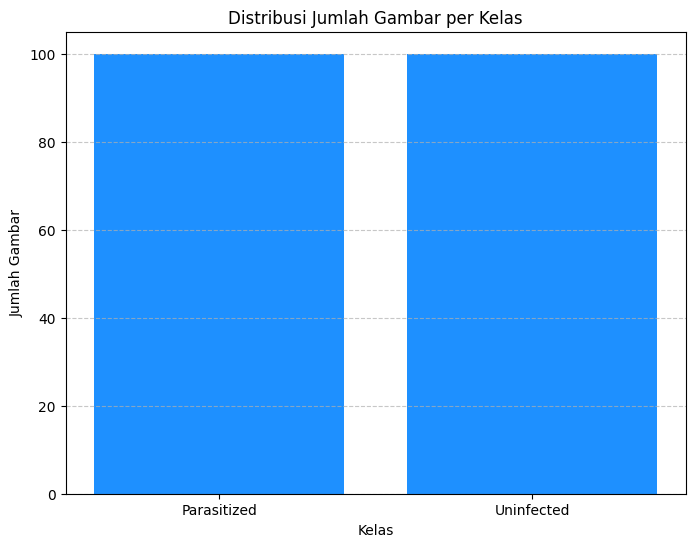

Output: Contoh Sample Data:


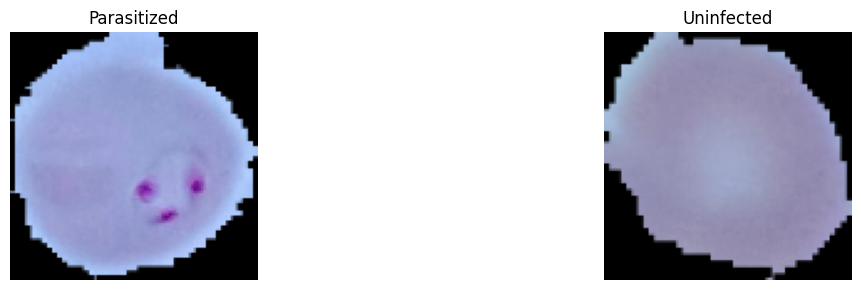

In [ ]:
label_counts = Counter(labels)
classes = list(label_counts.keys())
counts = list(label_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(classes, counts, color='dodgerblue')
plt.title("Distribusi Jumlah Gambar per Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("Output: Contoh Sample Data:")

plt.figure(figsize=(15, 3))
shown_labels = set()
shown = 0

for i in range(len(data)):
    label = labels[i]
    if label in shown_labels:
        continue
    plt.subplot(1, len(classes), shown + 1)
    plt.imshow(data[i], cmap='gray')
    plt.title(f"{label}")
    plt.axis('off')
    shown_labels.add(label)
    shown += 1
    if shown >= len(classes):
        break

plt.tight_layout()
plt.show()

In [ ]:
def prepro1_resize(img, new_width=100, new_height=100):
    old_height, old_width = img.shape[:2]
    resized = np.zeros((new_height, new_width, 3), dtype=np.uint8)

    for i in range(new_height):
        for j in range(new_width):
            x = int(i * old_height / new_height)
            y = int(j * old_width / new_width)
            resized[i, j] = img[x, y]
    return resized
def prepro2_grayscale(img):
    height, width = img.shape[:2]
    gray = np.zeros((height, width), dtype=np.uint8)

    for i in range(height):
        for j in range(width):
            r, g, b = img[i, j]
            gray[i, j] = int(0.2989 * r + 0.5870 * g + 0.1140 * b)  # Luminosity formula
    return gray
def prepro3_normalization(img):
    height, width = img.shape
    norm = np.zeros((height, width), dtype=np.float32)

    for i in range(height):
        for j in range(width):
            norm[i, j] = img[i, j] / 255.0
    return norm


Kode di atas memiliki tiga fungsi yang merupakan tahapan *preprocessing* (pra-pemrosesan) citra yang dilakukan secara manual tanpa menggunakan fungsi bawaan dari library seperti OpenCV. Fungsi `prepro1_resize()` berfungsi untuk mengubah ukuran gambar ke dimensi baru (default: 100×100 piksel) dengan cara menghitung posisi piksel asal dari dimensi lama dan menyalin warnanya ke posisi baru, sehingga menghasilkan citra yang telah di-*resize*. Selanjutnya, fungsi `prepro2_grayscale()` mengubah gambar berwarna (RGB) menjadi gambar keabuan (grayscale) menggunakan rumus luminositas (`0.2989 * R + 0.5870 * G + 0.1140 * B`) yang mempertimbangkan sensitivitas mata manusia terhadap warna, dan hasilnya disimpan sebagai citra satu kanal (1-channel). Terakhir, fungsi `prepro3_normalization()` melakukan normalisasi terhadap setiap piksel citra keabuan dengan membagi nilai pikselnya (0–255) menjadi rentang 0 hingga 1 (`/255.0`), sehingga memperbaiki skala data untuk keperluan model machine learning.

In [ ]:
output_folder = 'preprocessed_output1'
os.makedirs(output_folder, exist_ok=True)
dataPreprocessed = []

for i in range(len(data)):
    img = data[i]

    # === Tahapan Preprocessing Manual ===
    img_resized = prepro1_resize(img)            # Resize manual ke 100x100
    img_grayscale = prepro2_grayscale(img_resized)  # Konversi manual ke grayscale
    img_normalized = prepro3_normalization(img_grayscale)  # Normalisasi manual
    img_uint8 = (img_normalized * 255).astype(np.uint8) # ubah tipe data ke int untuk ekstraksi fitur
    dataPreprocessed.append(img_uint8)
    filename = file_name[i]
    save_path = os.path.join(output_folder, filename)
    cv.imwrite(save_path, img_uint8)

# Feature Extraction

In [ ]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")

    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

Pada kode di atas terdapat fungsi `glcm()` digunakan untuk menghitung matriks *Gray-Level Co-Occurrence Matrix* (GLCM), yaitu representasi statistik tekstur dari citra berdasarkan frekuensi kemunculan pasangan nilai piksel dengan jarak dan arah tertentu. Fungsi menerima dua parameter: `image` (citra dalam bentuk grayscale) dan `derajat` (sudut arah tekstur yang ingin dianalisis: 0, 45, 90, atau 135 derajat). Berdasarkan nilai `derajat`, fungsi akan mengatur nilai sudut `angles` dalam satuan radian menggunakan nilai dari `numpy` (`np.pi`). Jika sudut tidak valid, maka akan menghasilkan error melalui `raise ValueError`. Setelah sudut ditentukan, fungsi memanggil `graycomatrix()` dari pustaka `skimage.feature` untuk menghitung matriks GLCM pada jarak 1 piksel dengan opsi simetris (`symmetric=True`) dan ternormalisasi (`normed=True`). Hasilnya adalah sebuah matriks 4 dimensi yang menggambarkan sebaran tekstur dalam citra dan dapat digunakan untuk mengekstraksi fitur seperti kontras, homogenitas, energi, dan korelasi.


In [ ]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

Pada kode di atas terdapat kumpulan fungsi ini digunakan untuk mengekstraksi berbagai fitur tekstur dari matriks GLCM (Gray-Level Co-Occurrence Matrix) yang dihasilkan sebelumnya. Fungsi-fungsi seperti `correlation()`, `dissimilarity()`, `homogenity()`, `contrast()`, `ASM()` (Angular Second Moment), dan `energy()` memanfaatkan fungsi `graycoprops()` dari pustaka `skimage.feature` untuk menghitung masing-masing properti tekstur tersebut dari matriks GLCM, kemudian mengembalikan nilai skalar yang merepresentasikan karakteristik tekstur citra. Nilai-nilai ini membantu dalam mendeskripsikan pola tekstur seperti keteraturan, variasi, dan kontras antar piksel. Sedangkan fungsi `entropyGlcm()` menggunakan fungsi `entropy()` dari pustaka `scipy.stats` untuk menghitung entropi dari matriks GLCM yang sudah diratakan (`ravel()`), yang mengukur tingkat ketidakteraturan atau kompleksitas tekstur citra.

In [ ]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Kode di atas digunakan untuk menghitung dan menyimpan matriks GLCM (Gray-Level Co-Occurrence Matrix) dari setiap citra yang telah dipra-proses dalam list `dataPreprocessed` pada empat arah sudut berbeda: 0°, 45°, 90°, dan 135°. Dengan menggunakan loop `for` yang berjalan sepanjang jumlah citra, fungsi `glcm()` dipanggil untuk masing-masing sudut tersebut pada setiap citra. Hasil matriks GLCM dari setiap sudut disimpan secara terpisah dalam empat list berbeda, yaitu `Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135`. Pendekatan ini memungkinkan analisis tekstur citra dilakukan pada berbagai orientasi, sehingga fitur tekstur yang diperoleh lebih komprehensif dan dapat meningkatkan performa model klasifikasi.


In [ ]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

Kode di atas mendefinisikan beberapa list kosong yang akan digunakan untuk menyimpan nilai fitur tekstur yang diekstraksi dari matriks GLCM pada empat arah sudut berbeda: 0°, 45°, 90°, dan 135°. Setiap fitur tekstur, seperti kontras (`Kontras`), dissimilaritas (`dissimilarity`), homogenitas (`homogenity`), entropi (`entropy`), Angular Second Moment (`ASM`), energi (`energy`), dan korelasi (`correlation`), memiliki empat list yang terpisah, masing-masing untuk menyimpan hasil perhitungan pada setiap sudut tersebut. Dengan struktur ini, fitur tekstur dari seluruh citra dan setiap arah sudut akan diorganisir secara terpisah sehingga memudahkan analisis lebih lanjut dan penggabungan fitur dalam proses klasifikasi atau pengolahan citra berikutnya.


In [ ]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)
for i in range(len(dataPreprocessed)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)
for i in range(len(dataPreprocessed)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)
for i in range(len(dataPreprocessed)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)
for i in range(len(dataPreprocessed)):
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)
for i in range(len(dataPreprocessed)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)
for i in range(len(dataPreprocessed)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

Kode di atas melakukan ekstraksi fitur tekstur dari setiap matriks GLCM yang telah dihitung pada empat sudut berbeda (0°, 45°, 90°, dan 135°) untuk seluruh citra yang telah dipra-proses. Dengan menggunakan fungsi-fungsi seperti `correlation()`, `contrast()`, `dissimilarity()`, `homogenity()`, `entropyGlcm()`, `ASM()`, dan `energy()`, kode ini menghitung nilai masing-masing fitur tekstur dari matriks GLCM pada setiap sudut. Hasil ekstraksi fitur kemudian disimpan secara terpisah dalam list yang sesuai berdasarkan sudutnya, seperti `correlation0`, `Kontras45`, `dissimilarity90`, dan seterusnya. Proses ini mengorganisasi fitur tekstur untuk setiap citra dan setiap arah, yang nantinya dapat digunakan sebagai input fitur pada tahap pelatihan model machine learning atau analisis citra lebih lanjut.


In [ ]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak

,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,C33P1thinF_IMG_20150619_114756a_cell_179.png,Parasitized,567.011111,981.059178,552.255051,969.461177,0.534023,0.468131,0.528367,0.479464,...,0.070277,0.063047,0.264675,0.250963,0.265099,0.251091,0.949980,0.912238,0.951339,0.913275
1,C33P1thinF_IMG_20150619_114756a_cell_180.png,Parasitized,482.829495,999.626977,623.916566,939.817570,0.541985,0.479550,0.540982,0.482658,...,0.063445,0.057315,0.254326,0.238493,0.251884,0.239407,0.960143,0.916028,0.948392,0.921052
2,C33P1thinF_IMG_20150619_114756a_cell_181.png,Parasitized,513.236061,891.597898,500.379798,916.151107,0.488824,0.431694,0.494364,0.438714,...,0.046585,0.040369,0.215186,0.201094,0.215834,0.200919,0.943850,0.900317,0.945266,0.897572
3,C33P1thinF_IMG_20150619_114756a_cell_182.png,Parasitized,563.081818,966.057239,642.204545,1095.892358,0.559300,0.513458,0.559587,0.504776,...,0.098408,0.090285,0.314350,0.302430,0.313700,0.300475,0.961647,0.933552,0.956242,0.924621
4,C33P1thinF_IMG_20150619_115740a_cell_161.png,Parasitized,475.507172,828.910927,416.303333,749.968779,0.535679,0.464340,0.544090,0.479750,...,0.067272,0.059704,0.256105,0.243283,0.259368,0.244345,0.954252,0.919163,0.960057,0.926862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,C2NThinF_IMG_20150604_114730_cell_72.png,Uninfected,394.718788,842.800326,530.776566,797.500459,0.697791,0.621574,0.685162,0.631038,...,0.084731,0.076958,0.294141,0.276255,0.291086,0.277413,0.965783,0.925961,0.953958,0.929940
196,C2NThinF_IMG_20150604_114730_cell_98.png,Uninfected,478.829394,791.287726,466.864444,853.869299,0.678717,0.613056,0.657718,0.602215,...,0.102515,0.093720,0.319633,0.307146,0.320180,0.306136,0.958830,0.931347,0.959901,0.925918
197,C2NThinF_IMG_20150604_114751_cell_38.png,Uninfected,401.668182,698.697378,382.034747,665.819508,0.658870,0.576827,0.645972,0.589385,...,0.062527,0.056047,0.251230,0.235841,0.250053,0.236742,0.960785,0.930606,0.962711,0.933872
198,C2NThinF_IMG_20150604_114751_cell_69.png,Uninfected,380.830808,647.748393,403.102121,692.100194,0.676672,0.610119,0.675194,0.596021,...,0.056798,0.050158,0.239709,0.224912,0.238323,0.223960,0.962814,0.935562,0.960628,0.931150


Kode di atas membuat sebuah dictionary bernama `dataTable` yang berisi berbagai data penting hasil ekstraksi fitur tekstur dari citra, termasuk nama file (`Filename`), label kelas (`Label`), dan nilai-nilai fitur GLCM seperti kontras, homogenitas, dissimilaritas, entropi, ASM, energi, dan korelasi untuk keempat sudut (0°, 45°, 90°, dan 135°). Dictionary ini kemudian diubah menjadi sebuah DataFrame menggunakan `pd.DataFrame()`, yang memudahkan pengelolaan data dalam format tabel. Selanjutnya, DataFrame ini disimpan ke dalam file CSV bernama `'hasil_ekstraksi_1.csv'` tanpa menyertakan indeks baris (`index=False`). Terakhir, file CSV tersebut dibaca kembali ke dalam variabel `hasilEkstrak` menggunakan `pd.read_csv()` untuk memastikan data sudah tersimpan dengan benar dan siap digunakan pada tahap analisis atau pelatihan model selanjutnya.


# Feature Selection

In [ ]:
# Standardize the features
x_new = hasilEkstrak.drop(columns=['Label', 'Filename'])
y = hasilEkstrak['Label']
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_new)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
x_pca = pca.fit_transform(x_scaled)

# Display the explained variance ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Number of Components:", pca.n_components_)

# Create a DataFrame for the PCA-transformed features
pca_features = pd.DataFrame(x_pca, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
pca_features['Label'] = y
pca_features.head()

Explained Variance Ratio: [0.50175576 0.30685553 0.10276079 0.03538285 0.02790406]
Number of Components: 5


,PC1,PC2,PC3,PC4,PC5,Label
0,-4.862000,6.065060,-0.268912,0.191285,1.600135,Parasitized
1,-3.636370,5.175361,-1.165399,-1.693403,2.272675,Parasitized
2,-7.707283,5.061549,-0.239925,-0.155913,-0.014772,Parasitized
3,-1.215309,6.258140,-0.260185,-0.536809,3.134470,Parasitized
4,-3.864496,2.725578,0.867307,1.178735,1.224903,Parasitized


Kode di atas melakukan standarisasi fitur numerik pada dataset `hasilEkstrak` dengan menghilangkan kolom `Label` dan `Filename`, kemudian menggunakan `StandardScaler()` untuk mengubah data agar memiliki mean 0 dan standar deviasi 1, sehingga fitur menjadi lebih seimbang dan siap untuk analisis lebih lanjut. Setelah itu, diterapkan PCA (Principal Component Analysis) dengan parameter `n_components=0.95`, yang berarti PCA akan memilih jumlah komponen utama yang mampu mempertahankan 95% variansi dari data asli, sehingga mengurangi dimensi fitur secara signifikan tanpa kehilangan informasi penting. Hasil transformasi PCA disimpan dalam `x_pca`, dan informasi proporsi variansi yang dijelaskan oleh masing-masing komponen serta jumlah komponennya ditampilkan menggunakan `explained_variance_ratio_` dan `n_components_`. Selanjutnya, data hasil PCA ini dibuat dalam bentuk DataFrame baru yang diberi label kolom PC1, PC2, dan seterusnya sesuai jumlah komponen yang terpilih, dan kolom `Label` ditambahkan kembali agar data siap untuk tahap analisis atau pelatihan model selanjutnya, dengan tampilan awal data ditampilkan menggunakan `head()`.


In [ ]:
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(160, 28)
(40, 28)


Kode di atas membagi dataset fitur `x_new` dan label `y` menjadi dua bagian yaitu data latih (`X_train`, `y_train`) dan data uji (`X_test`, `y_test`) menggunakan fungsi `train_test_split` dari `sklearn.model_selection`. Parameter `test_size=0.2` berarti 20% data digunakan sebagai data uji, sedangkan 80% sisanya menjadi data latih, dan `random_state=42` memastikan pembagian data yang konsisten setiap kali kode dijalankan agar hasilnya dapat direproduksi. Setelah pembagian, bentuk (jumlah baris dan kolom) dari data latih dan data uji dicetak menggunakan `print()` untuk memastikan ukuran data sudah sesuai dengan proporsi yang diinginkan. Komentar di atas menunjukkan bahwa jika `test_size=0.3`, maka pembagian data adalah 70% untuk latih dan 30% untuk uji, sedangkan dengan `test_size=0.2`, pembagian menjadi 80% latih dan 20% uji.


In [ ]:
mean_train = X_train.mean(axis=0)
std_train = X_train.std(axis=0)

# Normalisasi data train dan test dengan Z-score
X_train = (X_train - mean_train) / std_train
X_test = (X_test - mean_train) / std_train

Kode di atas melakukan normalisasi data fitur untuk set pelatihan (`X_train`) dan pengujian (`X_test`) menggunakan metode Z-score. Pertama, dihitung nilai rata-rata (`mean_train`) dan standar deviasi (`std_train`) dari setiap fitur pada data pelatihan sepanjang axis 0 (kolom). Kemudian, normalisasi dilakukan dengan cara mengurangi setiap nilai fitur dengan rata-rata tersebut dan membaginya dengan standar deviasi, sehingga fitur menjadi memiliki distribusi dengan rata-rata 0 dan standar deviasi 1.

In [ ]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

Kode ini mendefinisikan sebuah fungsi `generateClassificationReport` yang menerima dua parameter, yaitu `y_true` (label asli) dan `y_pred` (label hasil prediksi), kemudian mencetak tiga hal penting untuk evaluasi performa model klasifikasi: laporan klasifikasi (`classification_report`) yang menampilkan metrik seperti precision, recall, dan F1-score, matriks kebingungan (`confusion_matrix`) yang memperlihatkan jumlah prediksi benar dan salah untuk tiap kelas, serta akurasi (`accuracy_score`) yang mengukur proporsi prediksi benar secara keseluruhan. Selain itu, kode ini juga mendefinisikan tiga model klasifikasi berbeda: `rf` yaitu Random Forest dengan 5 pohon keputusan dan pengacakan tetap (`random_state=42`), `svm` yaitu Support Vector Machine dengan kernel radial basis function (`rbf`), dan `knn` yaitu K-Nearest Neighbors dengan tetangga terdekat sebanyak 5.


In [ ]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

 Parasitized       0.99      0.96      0.97        79
  Uninfected       0.96      0.99      0.98        81

    accuracy                           0.97       160
   macro avg       0.98      0.97      0.97       160
weighted avg       0.98      0.97      0.97       160

[[76  3]
 [ 1 80]]
Accuracy: 0.975

------Testing Set------
              precision    recall  f1-score   support

 Parasitized       0.88      0.67      0.76        21
  Uninfected       0.71      0.89      0.79        19

    accuracy                           0.78        40
   macro avg       0.79      0.78      0.77        40
weighted avg       0.80      0.78      0.77        40

[[14  7]
 [ 2 17]]
Accuracy: 0.775


Kode di atas melakukan pelatihan model Random Forest (`rf`) menggunakan data pelatihan (`X_train` dan `y_train`), kemudian melakukan prediksi dan evaluasi model pada dua tahap. Pertama, model diuji pada data pelatihan itu sendiri, di mana prediksi hasil (`y_pred`) dibandingkan dengan label asli (`y_train`) untuk mengevaluasi seberapa baik model belajar dari data yang diberikan, lalu mencetak laporan klasifikasi dan metrik evaluasi menggunakan fungsi `generateClassificationReport`. Kedua, model diuji pada data pengujian (`X_test`), dimana prediksi dibandingkan dengan label asli pengujian (`y_test`) untuk mengukur performa model pada data baru yang belum pernah dilihat, juga menghasilkan laporan evaluasi yang dicetak.


In [ ]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

 Parasitized       0.99      0.94      0.96        79
  Uninfected       0.94      0.99      0.96        81

    accuracy                           0.96       160
   macro avg       0.96      0.96      0.96       160
weighted avg       0.96      0.96      0.96       160

[[74  5]
 [ 1 80]]
Accuracy: 0.9625

------Testing Set------
              precision    recall  f1-score   support

 Parasitized       0.90      0.90      0.90        21
  Uninfected       0.89      0.89      0.89        19

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40

[[19  2]
 [ 2 17]]
Accuracy: 0.9


Kode di atas melatih model Support Vector Machine (SVM) dengan kernel RBF menggunakan data pelatihan (`X_train`, `y_train`), lalu melakukan prediksi dan evaluasi performa model di dua tahap. Pertama, model diuji pada data pelatihan untuk melihat seberapa baik model bisa menyesuaikan diri dengan data yang dipelajari, dengan mencetak laporan klasifikasi dan matriks kebingungan melalui fungsi `generateClassificationReport`. Kedua, model diuji pada data pengujian (`X_test`), untuk mengukur kemampuan generalisasi model terhadap data baru yang belum pernah dilihat, dan hasil evaluasi yang sama juga dicetak.


In [ ]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

 Parasitized       0.96      0.91      0.94        79
  Uninfected       0.92      0.96      0.94        81

    accuracy                           0.94       160
   macro avg       0.94      0.94      0.94       160
weighted avg       0.94      0.94      0.94       160

[[72  7]
 [ 3 78]]
Accuracy: 0.9375

------Testing Set------
              precision    recall  f1-score   support

 Parasitized       0.89      0.76      0.82        21
  Uninfected       0.77      0.89      0.83        19

    accuracy                           0.82        40
   macro avg       0.83      0.83      0.82        40
weighted avg       0.83      0.82      0.82        40

[[16  5]
 [ 2 17]]
Accuracy: 0.825


Kode di atas melatih model K-Nearest Neighbors (KNN) dengan `k=5` menggunakan data pelatihan (`X_train`, `y_train`). Setelah model selesai dilatih, dilakukan prediksi dan evaluasi performa pada dua set data. Pertama, model diuji pada data pelatihan untuk melihat seberapa baik model dapat mengingat dan menyesuaikan diri dengan data yang digunakan selama pelatihan. Kedua, model diuji pada data pengujian (`X_test`) untuk mengukur kemampuan generalisasi model terhadap data baru yang belum pernah dilihat. Pada kedua tahap, hasil evaluasi seperti laporan klasifikasi, matriks kebingungan, dan akurasi dicetak menggunakan fungsi `generateClassificationReport` untuk memberikan gambaran performa KNN secara lengkap.


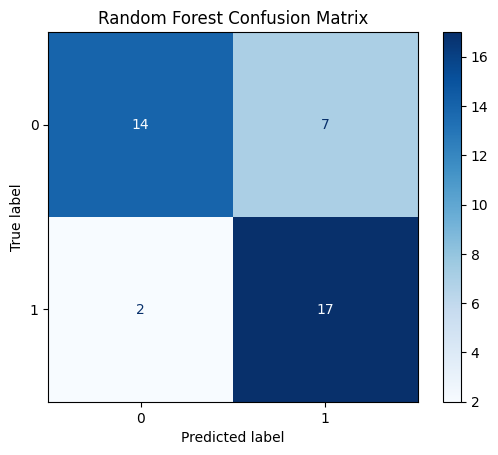

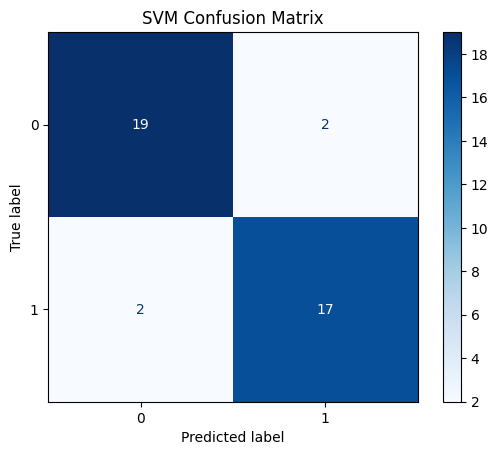

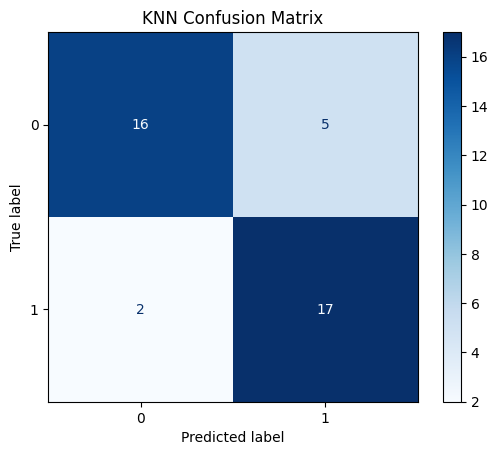

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")

Kode di atas membuat fungsi `plot_confusion_matrix` yang berfungsi untuk menampilkan matriks kebingungan dari hasil prediksi model klasifikasi. Fungsi menerima data label asli (`y_true`), hasil prediksi model (`y_pred`), dan judul grafik (`title`). Matriks kebingungan dihitung menggunakan `confusion_matrix`, lalu divisualisasikan dengan `ConfusionMatrixDisplay` dari sklearn dengan warna biru untuk membedakan tingkat kesalahan dan keberhasilan prediksi. Fungsi ini kemudian dipanggil tiga kali untuk masing-masing model: Random Forest, SVM, dan KNN, menampilkan matriks kebingungan dari prediksi data testing pada masing-masing model secara terpisah dengan judul yang sesuai.
